**Lab2 Part1.**
Carlos García 21000475

### Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from datetime import datetime, date

print(tf.__version__)

2.5.0-rc3


In [2]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


### Getting the data

In [3]:
#Based on file https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
data = pd.read_csv('./inputs/covid_data.csv')
data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,63819,64122,64575,65080,65486,65728,66275,66903,67743,68366
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,132071,132095,132118,132153,132176,132209,132215,132229,132244,132264
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,125693,125896,126156,126434,126651,126860,127107,127361,127646,127926
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,13569,13569,13569,13569,13569,13569,13569,13664,13671,13682
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,31045,31438,31661,31909,32149,32441,32623,32933,33338,33607


In [4]:
covid19_data = data.melt(id_vars = ['Province/State', 'Country/Region', 'Lat', 'Long'], var_name = 'Date', value_name = 'Confirmed')
covid19_data['Date'] = pd.to_datetime(covid19_data['Date'], format ='%m/%d/%y')
covid19_data.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0
1,NaN,Albania,41.15330,20.168300,2020-01-22,0
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0


In [5]:
covid19_data.dtypes

Province/State            object
Country/Region            object
Lat                      float64
Long                     float64
Date              datetime64[ns]
Confirmed                  int64
dtype: object

<AxesSubplot:xlabel='Date', ylabel='Confirmed'>

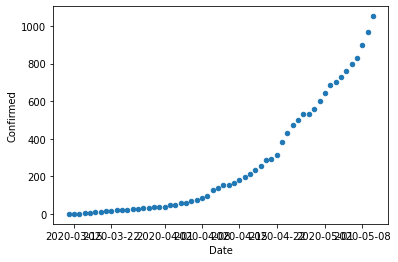

In [6]:
GT_confirmed = covid19_data[(covid19_data["Country/Region"] == 'Guatemala') & (covid19_data["Confirmed"] > 0)].copy()
GT_confirmed[GT_confirmed.Date <= '2020-05-10'].plot.scatter(x = "Date", y = "Confirmed")

<AxesSubplot:xlabel='Date', ylabel='ln(confirmed)'>

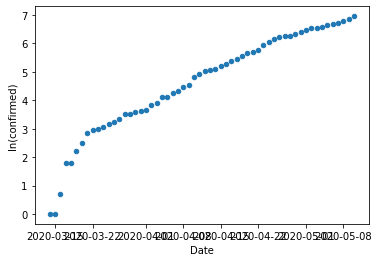

In [7]:
GT_confirmed["ln(confirmed)"] = np.log(GT_confirmed["Confirmed"])
GT_confirmed[GT_confirmed.Date <= '2020-05-10'].plot.scatter(x = "Date", y = "ln(confirmed)")

In [8]:
GT_confirmed.head(10)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,ln(confirmed)
14490,NaN,Guatemala,15.7835,-90.2308,2020-03-14,1,0.000000
14766,NaN,Guatemala,15.7835,-90.2308,2020-03-15,1,0.000000
15042,NaN,Guatemala,15.7835,-90.2308,2020-03-16,2,0.693147
15318,NaN,Guatemala,15.7835,-90.2308,2020-03-17,6,1.791759
15594,NaN,Guatemala,15.7835,-90.2308,2020-03-18,6,1.791759
15870,NaN,Guatemala,15.7835,-90.2308,2020-03-19,9,2.197225
16146,NaN,Guatemala,15.7835,-90.2308,2020-03-20,12,2.484907
16422,NaN,Guatemala,15.7835,-90.2308,2020-03-21,17,2.833213
16698,NaN,Guatemala,15.7835,-90.2308,2020-03-22,19,2.944439
16974,NaN,Guatemala,15.7835,-90.2308,2020-03-23,20,2.995732


<AxesSubplot:xlabel='Date', ylabel='ln(confirmed)'>

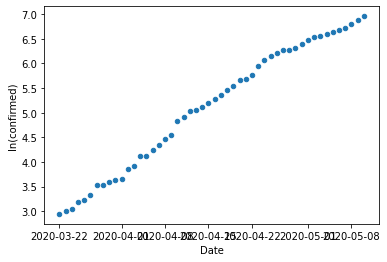

In [9]:
subGT_Confirmed = GT_confirmed[ (GT_confirmed.Date >= '2020-03-22') & (GT_confirmed.Date <= '2020-05-10')].copy()
subGT_Confirmed.plot.scatter(x = 'Date', y = 'ln(confirmed)')

In [10]:
subGT_Confirmed.sort_values(by = 'Date', ascending = True, inplace = True)
subGT_Confirmed.reset_index(inplace = True, drop = True)
subGT_Confirmed['day_number'] = subGT_Confirmed.index
subGT_Confirmed.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,ln(confirmed),day_number
0,NaN,Guatemala,15.7835,-90.2308,2020-03-22,19,2.944439,0
1,NaN,Guatemala,15.7835,-90.2308,2020-03-23,20,2.995732,1
2,NaN,Guatemala,15.7835,-90.2308,2020-03-24,21,3.044522,2
3,NaN,Guatemala,15.7835,-90.2308,2020-03-25,24,3.178054,3
4,NaN,Guatemala,15.7835,-90.2308,2020-03-26,25,3.218876,4


### Defining the model

In [11]:
def error(y, yhat):
    return 1/2 * tf.reduce_mean(tf.pow(y - yhat, 2))

In [12]:
def trainModel(x, y, epochs = 100, batch_size = 100, lr = 0.01, kprint = 10):

    #define total iterations
    iters = x.shape[0] // batch_size

    #initialize graph
    tf.reset_default_graph()

    #define tensors
    X = tf.placeholder(dtype = tf.float32, shape = [None, 2], name = 'tensor_x') #predictor
    Y = tf.placeholder(dtype = tf.float32, shape = [None, 1], name = 'tensor_y') #response
    W = tf.get_variable(name = 'parameters_m_b', dtype = tf.float32, shape = [2, 1], initializer = tf.zeros_initializer())

    #estimating values
    yhat = tf.matmul(X, W, name = 'Y_hat')

    #Cost/Error calculation
    with tf.name_scope('cost_definition'):
        cost = error(Y, yhat)

    #gradient and cost optimization
    with tf.name_scope('params_update'):
        gradients = tf.gradients(cost, [W], name = 'gradients')
        w_update = tf.assign(W, W - lr * gradients[0], name = 'weights_update')

    
    #Excecute session
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())

        #Reshaping data
        x = np.expand_dims(x, axis = 1) #x[:, np.newaxis]
        x = np.hstack((x, np.ones_like(x)))
        y = np.expand_dims(y, axis = 1) #y[:, np.newaxis]

        feed_dict_model = {X: x, Y: y} #whole batch dictionary

        for epoch in range(0, epochs):
            for i in range(0, iters):
                start_sample = i * batch_size
                end_sample = start_sample + batch_size
                x_mb = x[start_sample:end_sample]
                y_mb = y[start_sample:end_sample]

                feed_dict = {X: x_mb, Y: y_mb}
                _, weights = session.run([w_update, W], feed_dict = feed_dict)
            
            predictions = session.run(yhat, feed_dict = feed_dict_model)
            mse = session.run(cost, feed_dict = feed_dict_model)

            if (epoch + 1) % kprint == 0:
                m, b = weights[0, 0], weights[1, 0]
                print("Epoch {} parameters: m={} b={} mse={}".format(epoch + 1, m, b, mse))

        _, weights = session.run([w_update, W], feed_dict = feed_dict_model)
        predictions, mse = session.run([yhat, cost], feed_dict = feed_dict_model)
        m, b = weights[0, 0], weights[1, 0]

        print("Final model parameters: m={} b={} mse={}".format(m,b,mse))

        return(weights)
    

In [13]:
weights = trainModel(x = subGT_Confirmed['day_number'], y = subGT_Confirmed['ln(confirmed)'], epochs = 10000, batch_size = 50, lr = 0.001, kprint = 1000)

Epoch 1000 parameters: m=0.15651686489582062 b=0.6836221218109131 mse=0.6979243755340576
Epoch 2000 parameters: m=0.14062261581420898 b=1.2079654932022095 mse=0.421252965927124
Epoch 3000 parameters: m=0.12833504378795624 b=1.6133263111114502 mse=0.25589877367019653
Epoch 4000 parameters: m=0.11883577704429626 b=1.9267022609710693 mse=0.15707451105117798
Epoch 5000 parameters: m=0.11149205267429352 b=2.1689679622650146 mse=0.09801160544157028
Epoch 6000 parameters: m=0.10581479966640472 b=2.356257915496826 mse=0.0627126395702362
Epoch 7000 parameters: m=0.10142579674720764 b=2.501049041748047 mse=0.041615959256887436
Epoch 8000 parameters: m=0.09803277254104614 b=2.612982988357544 mse=0.029007595032453537
Epoch 9000 parameters: m=0.09540968388319016 b=2.699517250061035 mse=0.02147212252020836
Epoch 10000 parameters: m=0.09338182210922241 b=2.7664153575897217 mse=0.0169685035943985
Final model parameters: m=0.09338004887104034 b=2.7664740085601807 mse=0.01696505956351757


### Predictions

In [14]:
def predictConfirmedCases(dates, trainset, parameters):
    last_day, last_date = trainset['day_number'].max(), trainset['Date'].max()
    daydiffs = dates - last_date.date()
    days = [diff.days for diff in daydiffs]

    dayNumbers = days + last_day
    dayNumbers = np.expand_dims(dayNumbers, axis = 1)
    dayNumbers = np.hstack((dayNumbers, np.ones_like(dayNumbers)))
    predictions = np.exp(np.matmul(dayNumbers, parameters))

    predset = pd.DataFrame({'Date': dates, 'PredictedCases': np.ceil(predictions[:,0])})
    return(predset)


In [15]:
dates = np.array([date(2020, 5, 30)])
predictConfirmedCases(dates, subGT_Confirmed, weights)

,Date,PredictedCases
0,2020-05-30,9994.0
